In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from bqplot import pyplot as plt
#from bqplot import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set()

In [89]:
df = pd.read_csv('../data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1).fillna(0)

In [166]:
def arrhenius(T): # T for temperature
    R = 8.314
    return (2.25e-3) * np.exp(-14500/(R*T))

In [172]:
eq = 0 # for debugging purposes
def diffusion(t, T=1): # t for time
    D = arrhenius(T) #4.5e-6 # cm^2 / s
    r = 1.5      # cm
    k = (D*t)/(np.power(r, 2))
    eq = np.exp(np.asarray([
        -5.785 * k,
        -30.5 * k,
        -74.9 * k,
        -139 * k,
        -223 * k
    ]))
    coefs = np.array([-0.692, 0.190, 0.0775, 0.0415, 0.0258])
    return 1 - np.sum(np.multiply(eq, coefs))

In [146]:
df.Time -= 1.700 # reset to 0

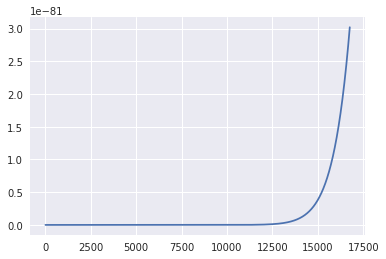

In [209]:
plt.plot(df.Time, df.Time.apply(lambda t: arrhenius(np.log(t))))

In [231]:
#df['Diffusion'] = df.Time.apply(lambda t: diffusion(t))
df['Diffusion'] = df.Time.apply(lambda t: diffusion(t, 353))
df['CDiffusion'] = df.Time.apply(lambda t: diffusion(t, 328))
df.Diffusion.fillna(0, inplace=True); df.CDiffusion.fillna(0, inplace=True)

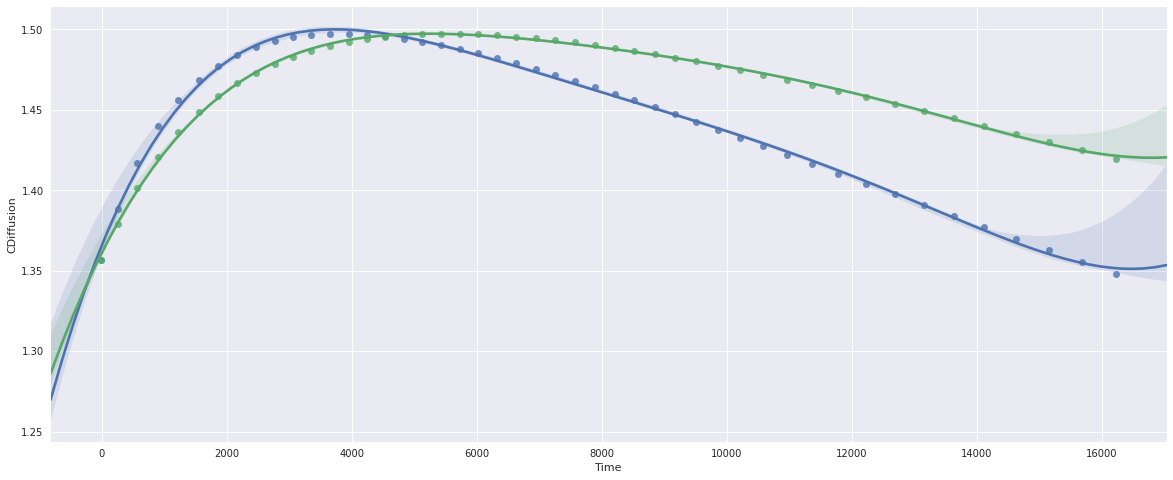

In [236]:
fig, ax = plt.subplots(figsize=(20,8))
sns.regplot('Time', 'Diffusion', df[df.Min==1], fit_reg=True, order=5, ax=ax) # concentration of ethanol in mnuscle
sns.regplot('Time', 'CDiffusion', df[df.Min==1], fit_reg=True, order=5, ax=ax)

### Scale data
to compare `Heating`, `Cooling`, `Diffusion` characteristics.

In [219]:
from sklearn.preprocessing import StandardScaler

In [237]:
scaler = StandardScaler()
X = pd.DataFrame(df[df.Min==1].Time)

features_to_scale = df[df.Min==1].drop('Datetime', axis=1).columns.tolist()[1:]
for f in features_to_scale:
    X[f] = scaler.fit(df[df.Min==1][f].reshape(-1,1)).transform(df[df.Min==1][f].reshape(-1,1))
X.Inv = -X.Diffusion.iloc[::-1]
#X_heating = scaler.fit(X.Heating.reshape(-1, 1)).transform(X.Heating.reshape(-1, 1))
#X_cooling = scaler.fit(X.Cooling.areshape(-1, 1)).transform(X.Cooling.reshape(-1, 1))
#X_diffusion = scaler.fit(X.Diffusion.reshape(-1, 1)).transform(X.Diffusion.reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


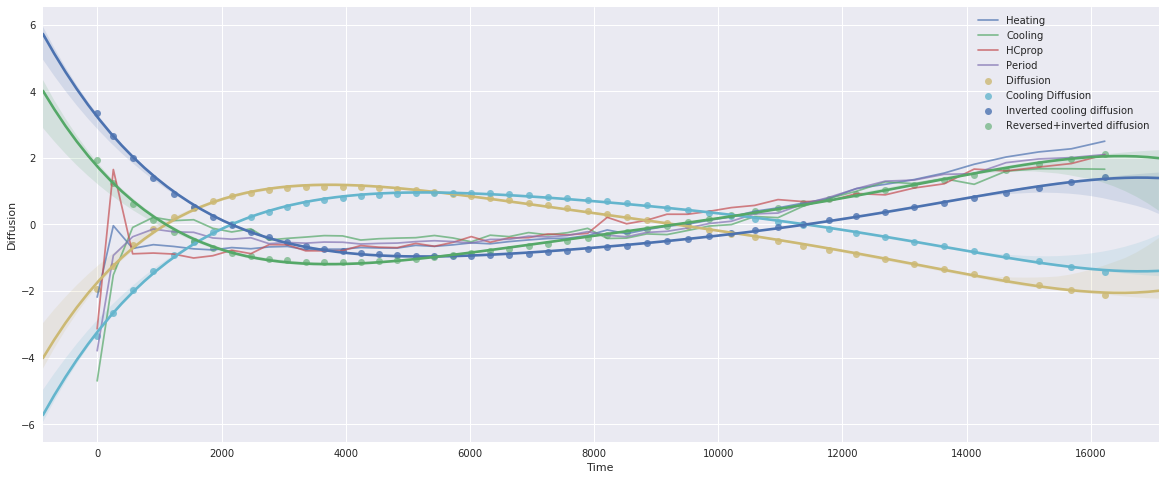

In [243]:
fig, ax = plt.subplots(figsize=(20,8))
for f in ['Heating', 'Cooling', 'HCprop', 'Period']: # 'Area', 'Belly'
    ax.plot(X.Time, X[f], alpha=0.7)

#ax.plot(X.Time, X.Diffusion)
#ax.plot(X.Time, X.Inv)
sns.regplot(X.Time, X.Diffusion, order=5, ax=ax, label='Diffusion')
sns.regplot(X.Time, X.CDiffusion, order=5, ax=ax, label='Cooling Diffusion')
#sns.regplot(X.Time, -X.Diffusion.iloc[::-1], order=5, ax=ax, label='Reversed+inverted diffusion', scatter_kws={'alpha': 0.6})
sns.regplot(X.Time, -X.CDiffusion, order=5, ax=ax, label='Inverted cooling diffusion')
sns.regplot(X.Time, -X.Diffusion, order=5, ax=ax, label='Reversed+inverted diffusion', scatter_kws={'alpha': 0.6})
ax.legend();

### Regress on scaled data

In [239]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [178]:
pipe = make_pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('lr', Ridge())
])



steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gaussiannb', GaussianNB(priors=None))])

SyntaxError: invalid syntax (<ipython-input-178-d299603cb2ab>, line 11)